# LAB 9: Transfer learning

Objectives:
- apply NLI + zero-shot learning 
- build a classifier using contextual word vectors
- fine tune distilbert for wine classification

**Important:** This notebook needs a GPU to work properly! If you're on google colab, choose Runtime > Change runtime type, and make sure Hardware Accelerator is set to GPU.

Set up transformers library

In [1]:
!pip -q install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 3.7 MB/s eta 0:00:00


In [5]:
import warnings
import torch
import torchtext

from transformers import AutoTokenizer, pipeline
from datasets import DatasetDict, Dataset

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

If you get an error here then double check that you've got the right kind of runtime (see comment above about GPUs)

In [6]:
DEVICE = 'cuda:0'
dev = torch.cuda.get_device_properties(0)
print(f"Using device: {dev.name} ({dev.total_memory/1024/1024/1024:.1f}gb)")

Using device: Tesla T4 (14.7gb)


----

## Load data

In [7]:
torchtext.utils.download_from_url('http://malouf.sdsu.edu/files/wine-data.tar.gz', root='./')
torchtext.utils.extract_archive('/content/wine-data.tar.gz', './')


100%|██████████| 14.6M/14.6M [00:02<00:00, 7.31MB/s]


['./wine-train.parquet', './wine-test.parquet']

In [8]:
ds = DatasetDict({'train':Dataset.from_parquet('wine-train.parquet'),
                  'test':Dataset.from_parquet('wine-test.parquet')})

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/default-1f610d2531230974/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/default-97f6351d1273668c/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


## Zero-shot classification

So-called "zero-shot classification" uses no specialized training data. Instead, it uses a model trained on general inference and applies it to solve a specific problem. The model is presented with the text of the review and then given the query: "The variety of wine this describes is ___". Its task is to fill in the blank.

The model we'll start with is called [typeform/distilbert-base-uncased-mnli](https://huggingface.co/typeform/distilbert-base-uncased-mnli). It is an instance of the [distilBERT](https://paperswithcode.com/method/distillbert) model fine-tuned on the [ Multi-Genre Natural Language Inference (MultiNLI) corpus](https://cims.nyu.edu/~sbowman/multinli/).


Things to experiment with:
- Change the query.
- Try a different model. Here is [a list of HuggingFace models that support zero-shot classification](https://huggingface.co/models?pipeline_tag=zero-shot-classification&sort=downloads).

In [9]:
MODEL_CKPT = 'typeform/distilbert-base-uncased-mnli'

guesser = pipeline(model=MODEL_CKPT, 
                   task='zero-shot-classification', 
                   device=DEVICE)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [10]:
labels = list(set(ds['train']['wine_variant']))
small_test = ds['test'].select(range(500))

In [11]:
%%time

with warnings.catch_warnings():
  warnings.simplefilter('ignore')
  output = guesser(small_test['review_text'], 
                    candidate_labels=labels, 
                    hypothesis_template="The variety of wine this describes is {}.")
  predicted = [o['labels'][0] for o in output]


CPU times: user 26.9 s, sys: 106 ms, total: 27 s
Wall time: 28.9 s


In [12]:
print(classification_report(small_test['wine_variant'], predicted))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.37      0.14      0.21       112
        Chardonnay       0.20      0.49      0.29        75
            Merlot       0.11      0.52      0.18        23
        Pinot Noir       1.00      0.14      0.25       140
          Riesling       0.43      0.32      0.37        37
   Sauvignon Blanc       0.11      0.26      0.15        19
             Syrah       0.38      0.35      0.36        60
         Zinfandel       0.75      0.26      0.39        34

          accuracy                           0.26       500
         macro avg       0.42      0.31      0.27       500
      weighted avg       0.53      0.26      0.27       500



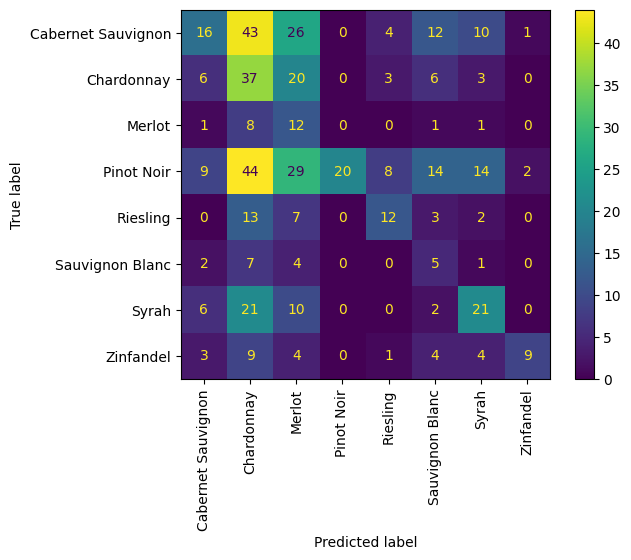

In [13]:
ConfusionMatrixDisplay.from_predictions(small_test['wine_variant'], predicted, xticks_rotation=90)

Describe what you did and what you learned from these experiments:

In [14]:
MODEL_CKPT = 'facebook/bart-large-mnli'

guesser = pipeline(model=MODEL_CKPT, 
                   task='zero-shot-classification', 
                   device=DEVICE)

In [16]:
%%time

with warnings.catch_warnings():
  warnings.simplefilter('ignore')
  output = guesser(small_test['review_text'], 
                    candidate_labels=labels, 
                    hypothesis_template="The variety of wine this describes is {}.")
  predicted = [o['labels'][0] for o in output]


CPU times: user 2min 37s, sys: 410 ms, total: 2min 38s
Wall time: 2min 47s


In [17]:
print(classification_report(small_test['wine_variant'], predicted))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.38      0.63      0.48       112
        Chardonnay       0.53      0.28      0.37        75
            Merlot       0.75      0.39      0.51        23
        Pinot Noir       0.88      0.25      0.39       140
          Riesling       0.73      0.30      0.42        37
   Sauvignon Blanc       0.09      0.74      0.16        19
             Syrah       0.47      0.35      0.40        60
         Zinfandel       0.91      0.29      0.44        34

          accuracy                           0.38       500
         macro avg       0.59      0.40      0.40       500
      weighted avg       0.62      0.38      0.41       500



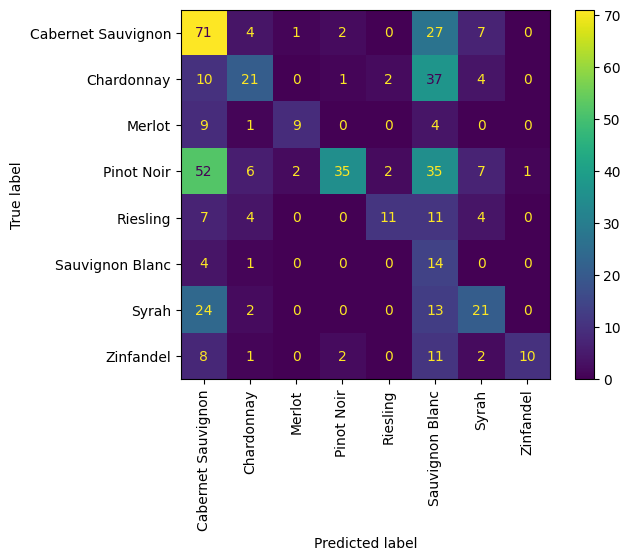

In [18]:
ConfusionMatrixDisplay.from_predictions(small_test['wine_variant'], predicted, xticks_rotation=90)

In [19]:
%%time

with warnings.catch_warnings():
  warnings.simplefilter('ignore')
  output = guesser(small_test['review_text'], 
                    candidate_labels=labels, 
                    hypothesis_template="This best suits {} wine variety.")
  predicted = [o['labels'][0] for o in output]


CPU times: user 2min 39s, sys: 470 ms, total: 2min 39s
Wall time: 2min 45s


In [20]:
print(classification_report(small_test['wine_variant'], predicted))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.67      0.43      0.52       112
        Chardonnay       0.28      0.41      0.33        75
            Merlot       0.26      0.43      0.33        23
        Pinot Noir       0.62      0.41      0.50       140
          Riesling       0.73      0.30      0.42        37
   Sauvignon Blanc       0.15      0.74      0.25        19
             Syrah       0.40      0.40      0.40        60
         Zinfandel       0.58      0.32      0.42        34

          accuracy                           0.41       500
         macro avg       0.46      0.43      0.40       500
      weighted avg       0.53      0.41      0.44       500



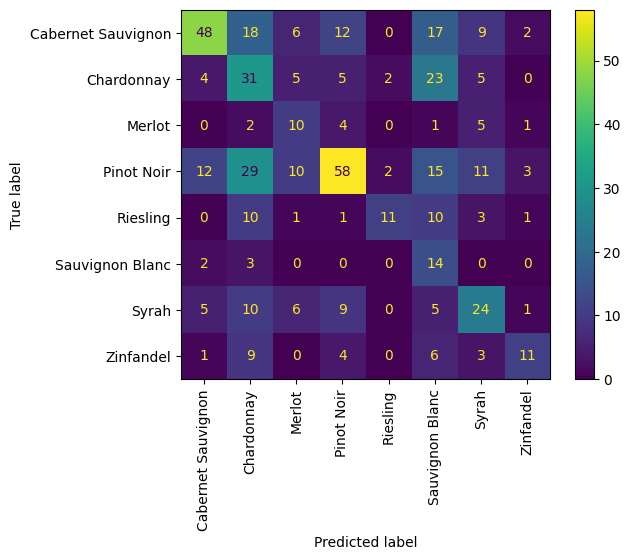

In [21]:
ConfusionMatrixDisplay.from_predictions(small_test['wine_variant'], predicted, xticks_rotation=90)

**OBSERVATIONS:**

1. First thing I tried is to change the model to 'facebook/bart-large-mnli'.
2. It performed better than the distilbert model but both are very behind the general classifiers trained on some training data.
3. Then using the same facebook model, changed the query and found a little improvement in the accuracy.
4. As we are not training these models on our specific task, and they are using general query to solve the task at hand, they are not particularly great at accuracy.
5. Also, depending on the query, the true positive predictions of particular classes changed which seems interesting!